In [1]:
!pip install -q -U autogluon.tabular

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.0 requires aiohttp<4.0.0,>=3.9.2, which is not installed.
s3fs 2024.3.1 requires aiohttp!=4.0.0a0,!=4.0.0a1, which is not installed.
aiobotocore 2.13.0 requires botocore<1.34.107,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


# Imports and Configs

In [2]:
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import glob

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

In [3]:
TIME_LIMIT = 3600 * 11
N_FOLDS = 5
SEED = 27
TARGET = 'Target'

# Loading and Combining the Datasets

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [5]:
original = pd.read_csv('/kaggle/input/predict-students-dropout-and-academic-success/data.csv')
train = pd.concat([train, original], axis=0, ignore_index=True)

train.shape

(80942, 37)

In [6]:
train = TabularDataset(train)
test = TabularDataset(test)

# Training

In [7]:
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

histories = {}
oof_preds = np.zeros((len(train), train[TARGET].nunique()))
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train.drop(columns=TARGET), train[TARGET])):
    _train, _val = train.iloc[train_idx], train.iloc[val_idx]    

    predictor = TabularPredictor(
        label=TARGET,
        eval_metric='accuracy',
        problem_type='multiclass',
        verbosity=2
    ).fit(
        train_data=_train,
        time_limit=TIME_LIMIT // N_FOLDS,
        presets='best_quality',
        excluded_model_types = ['KNN', 'NN', 'NN_TORCH', 'FASTAI', 'RF'],
        save_space=True,
        hyperparameter_tune_kwargs={  
            'num_trials': 25,
            'scheduler' : 'local',
            'searcher'  : 'auto'
        },
        feature_prune_kwargs={'force_prune': True}
    )
    
    fold_score = predictor.evaluate(_val)['accuracy']
    
    pred_probs = predictor.predict_proba(_val)
    preds = pred_probs.idxmax(axis=1).values
    oof_preds[val_idx] = pred_probs
    
    test_pred_probs = predictor.predict_proba(test)
    
    test_preds = test_pred_probs.idxmax(axis=1).values
    test_preds = pd.DataFrame({TARGET: test_preds}, index=test.index)
    test_preds.to_csv(f'fold_{fold_idx}_test_preds_{fold_score:.6f}.csv')
    
    test_pred_probs = pd.DataFrame(test_pred_probs, index=test.index)
    test_pred_probs.to_csv(f'fold_{fold_idx}_test_pred_probs_{fold_score:.6f}.csv')
    
    histories[f'Fold {fold_idx}'] = {}
    histories[f'Fold {fold_idx}']['summary'] = predictor.fit_summary()
    histories[f'Fold {fold_idx}']['leaderboard'] = predictor.leaderboard()
    histories[f'Fold {fold_idx}']['y'] = _val[TARGET].values
    histories[f'Fold {fold_idx}']['pred_probs'] = pred_probs
    histories[f'Fold {fold_idx}']['preds'] = preds
    histories[f'Fold {fold_idx}']['accuracy'] = fold_score
    histories[f'Fold {fold_idx}']['auc'] = roc_auc_score(_val[TARGET], pred_probs, multi_class='ovo')
    
    
    print(f'Fold {fold_idx} - Accuracy: {fold_score}')
    
    shutil.rmtree("AutogluonModels")
    del predictor

No path specified. Models will be saved in: "AutogluonModels/ag-20240602_075450"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240602_075450/ds_sub_fit/sub_fit_ho.
2024-06-02 07:54:52,056	INFO util.py:124 -- Outdated packages:
  ipywidgets==7

  0%|          | 0/25 [00:00<?, ?it/s]

Will use sequential fold fitting strategy because import of ray failed. Reason: ray==2.9.0 detected. 2.10.0 <= ray < 2.11.0 is required. You can use pip to install certain version of ray `pip install ray==2.10.0` 
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 44. Best iteration is:
	[42]	valid_set's multi_error: 0.179708
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 26. Best iteration is:
	[26]	valid_set's multi_error: 0.176095
	Ran out of time, early stopping on iteration 26. Best iteration is:
	[26]	valid_set's multi_error: 0.184712
	Ran out of time, early stopping on iteration 28. Best iteration is:
	[25]	valid_set's multi_error: 0.183461
	Ran out of time, early stopping on iteration 27. Best iteration is:
	[27]	valid_set's multi_error: 0.179569
	Ran out of time, early stopping on iteration 28. Best iteration 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 43. Best iteration is:
	[43]	valid_set's multi_error: 0.17123
	Ran out of time, early stopping on iteration 44. Best iteration is:
	[40]	valid_set's multi_error: 0.178318
	Ran out of time, early stopping on iteration 48. Best iteration is:
	[47]	valid_set's multi_error: 0.178596
	Ran out of time, early stopping on iteration 52. Best iteration is:
	[52]	valid_set's multi_error: 0.175817
	Ran out of time, early stopping on iteration 51. Best iteration is:
	[47]	valid_set's multi_error: 0.179569
	Ran out of time, early stopping on iteration 58. Best iteration is:
	[56]	valid_set's multi_error: 0.170813
	Ran out of time, early stopping on iteration 64. Best iteration is:
	[64]	valid_set's multi_error: 0.177648
	Ran out of time, early stopping on iteration 76. Best iteration is:
	[65]	valid_set's multi_error: 0.18571
	Stopping HPO to satisfy time limit...
Fit

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 24.
	Ran out of time, early stopping on iteration 39.
	Ran out of time, early stopping on iteration 41.
	Ran out of time, early stopping on iteration 43.
	Ran out of time, early stopping on iteration 45.
	Ran out of time, early stopping on iteration 49.
	Ran out of time, early stopping on iteration 51.
	Ran out of time, early stopping on iteration 66.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8122	 = Validation score   (accuracy)
	18.59s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1917.91s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Not enough time to generate out-of-fold predictions for model. Estimated 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8255	 = Validation score   (accuracy)
	18.83s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1871.54s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 33. Best iteration is:
	[33]	valid_set's multi_error: 0.171647
	Ran out of time, early stopping on iteration 30. Best iteration is:
	[30]	valid_set's multi_error: 0.180542
	Ran out of time, early stopping on iteration 31. Best iteration is:
	[31]	valid_set's multi_error: 0.181654
	Ran out of time, early stopping on iteration 31. Best iteration is:
	[31]	valid_set's multi_error: 0.178735
	Ran out of time, early stopping on iteration 33. Best iteration is:
	[33]	valid_set's multi_error: 0.18137

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 14.22s of the 853

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 14.22s of the 838.5

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 14.22s of the 824.58

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 14.22s of the 775.23s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 14.22s of the 771.22s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L2. Skipping HPO. Will train one model based on the provided hyperpara

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 173. Best iteration is:
	[172]	valid_set's multi_error: 0.169858
	Ran out of time, early stopping on iteration 152. Best iteration is:
	[140]	valid_set's multi_error: 0.173956
	Ran out of time, early stopping on iteration 147. Best iteration is:
	[146]	valid_set's multi_error: 0.175562
	Ran out of time, early stopping on iteration 145. Best iteration is:
	[138]	valid_set's multi_error: 0.171114
	Ran out of time, early stopping on iteration 168. Best iteration is:
	[168]	valid_set's multi_error: 0.171485
	Ran out of time, early stopping on iteration 212. Best iteration is:
	[210]	valid_set's multi_error: 0.171856
	Ran out of time, early stopping on iteration 225. Best iteration is:
	[224]	valid_set's multi_error: 0.180133
	Ran out of time, early stopping on iteration 259. Best iteration is:
	[232]	valid_set's multi_error: 0.172844
	Stopping HPO to satisfy

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 189. Best iteration is:
	[184]	valid_set's multi_error: 0.168643
	Ran out of time, early stopping on iteration 194. Best iteration is:
	[192]	valid_set's multi_error: 0.171979
	Ran out of time, early stopping on iteration 214. Best iteration is:
	[157]	valid_set's multi_error: 0.16469
	Ran out of time, early stopping on iteration 233. Best iteration is:
	[204]	valid_set's multi_error: 0.169014
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.8302	 = Validation score   (accuracy)
	60.95s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 68.51s of the 6158.53s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 125.
	Ran out of time, early stopping on iteration 130.
	Ran out of time, early stopping on iteration 134.
	Ran out of time, early stopping on iteration 134.
	Ran out of time, early stopping on iteration 149.
	Ran out of time, early stopping on iteration 161.
	Ran out of time, early stopping on iteration 180.
	Ran out of time, early stopping on iteration 206.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.822	 = Validation score   (accuracy)
	60.87s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 68.51s of the 6097.5s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8217	 = Validation score 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8301	 = Validation score   (accuracy)
	52.14s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 68.51s of the 5993.92s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 100. Best iteration is:
	[95]	valid_set's multi_error: 0.170599
	Ran out of time, early stopping on iteration 96. Best iteration is:
	[96]	valid_set's multi_error: 0.173462
	Ran out of time, early stopping on iteration 97. Best iteration is:
	[96]	valid_set's multi_error: 0.175315
	Ran out of time, early stopping on iteration 105. Best iteration is:
	[75]	valid_set's multi_error: 0.169138
	Ran out of time, early stopping on iteration 81. Best iteration is:
	[78]	valid_set's multi_error: 0.171

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's multi_error: 0.183447
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 7. Best iteration is:
	[7]	valid_set's multi_error: 0.183694
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 4. Best iteration is:
	[4]	valid_set's multi_error: 0.26992
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524521
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524521
	Fitting 8 child models 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 6. Best iteration is:
	[6]	valid_set's multi_error: 0.235701
	Ran out of time, early stopping on iteration 7. Best iteration is:
	[7]	valid_set's multi_error: 0.213121
	Ran out of time, early stopping on iteration 8. Best iteration is:
	[8]	valid_set's multi_error: 0.194589
	Ran out of time, early stopping on iteration 8. Best iteration is:
	[8]	valid_set's multi_error: 0.199407
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.185817
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.190264
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.187917
	Ran out of time, early stopping on iteration 12. Best iteration is:
	[12]	valid_set's multi_error: 0.175686
	Stopping HPO to satisfy time limit...
Fitted model: L

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 7.
	Ran out of time, early stopping on iteration 7.
	Ran out of time, early stopping on iteration 1.
	Ran out of time, early stopping on iteration 3.
	Ran out of time, early stopping on iteration 3.
	Ran out of time, early stopping on iteration 4.
	Ran out of time, early stopping on iteration 6.
	Ran out of time, early stopping on iteration 9.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	0.8285	 = Validation score   (accuracy)
	41.06s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 49.33s of the 2880.33s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L2 ...
	0.8277	 = Validation score   (accuracy)
	

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 49.33s of the 2

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.832471    accuracy       1.339209  3446.818912                0.009752           4.865366            3       True        108
1       WeightedEnsemble_L2   0.832286    accuracy       0.016709   224.598553                0.009976           5.127959            2       True         56
2      LightGBM_r130_BAG_L1   0.831977    accuracy       0.001650    59.130305                0.001650          59.130305            1       True         18
3        XGBoost_r89_BAG_L2   0.831683    accuracy       1.324754  3301.057703                0.001677          47.565320            2       True         70
4        XGBoost_r22_BAG_L1   0.831622    accuracy       0.001627    61.409357                0.001627          61.409357            1       True        

No path specified. Models will be saved in: "AutogluonModels/ag-20240602_100935"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240602_100935/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1980s
AutoGluon will save models

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 46. Best iteration is:
	[44]	valid_set's multi_error: 0.184017
	Ran out of time, early stopping on iteration 44. Best iteration is:
	[41]	valid_set's multi_error: 0.180681
	Ran out of time, early stopping on iteration 45. Best iteration is:
	[43]	valid_set's multi_error: 0.18221
	Ran out of time, early stopping on iteration 40. Best iteration is:
	[40]	valid_set's multi_error: 0.188047
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[53]	valid_set's multi_error: 0.185546
	Ran out of time, early stopping on iteration 54. Best iteration is:
	[53]	valid_set's multi_error: 0.179986
	Ran out of time, early stopping on iteration 57. Best iteration is:
	[53]	valid_set's multi_error: 0.183486
	Ran out of time, early stopping on iteration 71. Best iteration is:
	[70]	valid_set's multi_error: 0.178899
	Stopping HPO to satisfy time limit...
Fi

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 42. Best iteration is:
	[42]	valid_set's multi_error: 0.177623
	Ran out of time, early stopping on iteration 44. Best iteration is:
	[44]	valid_set's multi_error: 0.175122
	Ran out of time, early stopping on iteration 44. Best iteration is:
	[43]	valid_set's multi_error: 0.172759
	Ran out of time, early stopping on iteration 45. Best iteration is:
	[45]	valid_set's multi_error: 0.178874
	Ran out of time, early stopping on iteration 38. Best iteration is:
	[37]	valid_set's multi_error: 0.181793
	Ran out of time, early stopping on iteration 21. Best iteration is:
	[18]	valid_set's multi_error: 0.185129
	Ran out of time, early stopping on iteration 24. Best iteration is:
	[23]	valid_set's multi_error: 0.186405
	Ran out of time, early stopping on iteration 24. Best iteration is:
	[24]	valid_set's multi_error: 0.183486
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 18.
	Ran out of time, early stopping on iteration 14.
	Ran out of time, early stopping on iteration 21.
	Ran out of time, early stopping on iteration 22.
	Ran out of time, early stopping on iteration 23.
	Ran out of time, early stopping on iteration 24.
	Ran out of time, early stopping on iteration 30.
	Ran out of time, early stopping on iteration 46.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.809	 = Validation score   (accuracy)
	18.57s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1922.61s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Not enough time to generate out-of-fold predictions for model. Estimated t

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8275	 = Validation score   (accuracy)
	18.86s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1878.08s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 26. Best iteration is:
	[26]	valid_set's multi_error: 0.1836
	Ran out of time, early stopping on iteration 27. Best iteration is:
	[27]	valid_set's multi_error: 0.179847
	Ran out of time, early stopping on iteration 27. Best iteration is:
	[27]	valid_set's multi_error: 0.17665
	Ran out of time, early stopping on iteration 28. Best iteration is:
	[27]	valid_set's multi_error: 0.187769
	Ran out of time, early stopping on iteration 30. Best iteration is:
	[28]	valid_set's multi_error: 0.186379
	

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 14.46s of the 867

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 14.46s of the 852.6

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 14.46s of the 787.82s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 14.46s of the 782.66s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L2. Skipping HPO. Will train one model based on the provided hyperpara

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 288. Best iteration is:
	[269]	valid_set's multi_error: 0.178774
	Ran out of time, early stopping on iteration 307. Best iteration is:
	[239]	valid_set's multi_error: 0.164443
	Ran out of time, early stopping on iteration 309. Best iteration is:
	[306]	valid_set's multi_error: 0.171362
	Ran out of time, early stopping on iteration 333. Best iteration is:
	[323]	valid_set's multi_error: 0.171485
	Ran out of time, early stopping on iteration 351. Best iteration is:
	[307]	valid_set's multi_error: 0.164196
	Ran out of time, early stopping on iteration 373. Best iteration is:
	[327]	valid_set's multi_error: 0.170373
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	0.8289	 = Validation score   (accuracy)
	86.49s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ... Tuning model for up 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 309. Best iteration is:
	[242]	valid_set's multi_error: 0.164422
	Ran out of time, early stopping on iteration 313. Best iteration is:
	[233]	valid_set's multi_error: 0.17408
	Ran out of time, early stopping on iteration 337. Best iteration is:
	[248]	valid_set's multi_error: 0.159748
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.8315	 = Validation score   (accuracy)
	66.23s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 102.85s of the 6132.45s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 199.
	Ran out of time, early stopping on iteration 204.
	Ran out of time, early stopping on iteration 216.
	Ran out of time, early stopping on iteration 222.
	Ran out of time, early stopping on iteration 229.
	Ran out of time, early stopping on iteration 251.
	Ran out of time, early stopping on iteration 274.
	Ran out of time, early stopping on iteration 332.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8252	 = Validation score   (accuracy)
	93.85s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 102.85s of the 6038.45s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8217	 = Validation sco

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8326	 = Validation score   (accuracy)
	75.21s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 102.85s of the 5914.08s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 144. Best iteration is:
	[113]	valid_set's multi_error: 0.168623
	Ran out of time, early stopping on iteration 154. Best iteration is:
	[152]	valid_set's multi_error: 0.176674
	Ran out of time, early stopping on iteration 156. Best iteration is:
	[156]	valid_set's multi_error: 0.163702
	Ran out of time, early stopping on iteration 162. Best iteration is:
	[134]	valid_set's multi_error: 0.170002
	Ran out of time, early stopping on iteration 167. Best iteration is:
	[164]	valid_set's multi_err

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2   0.833042    accuracy       0.017384  268.408035                0.011539           4.977134            2       True         56
1       XGBoost_r89_BAG_L1   0.832981    accuracy       0.001657   73.876122                0.001657          73.876122            1       True         17
2        XGBoost_BAG_L1/T1   0.832610    accuracy       0.001722   75.214325                0.001722          75.214325            1       True          6
3       XGBoost_r95_BAG_L1   0.832317    accuracy       0.001668   91.202744                0.001668          91.202744            1       True         53
4     LightGBM_r130_BAG_L1   0.832023    accuracy       0.002210   55.843723                0.002210          55.843723            1       True         18
5      X

No path specified. Models will be saved in: "AutogluonModels/ag-20240602_115456"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240602_115456/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1980s
AutoGluon will save models

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 18. Best iteration is:
	[18]	valid_set's multi_error: 0.21237
	Ran out of time, early stopping on iteration 18. Best iteration is:
	[18]	valid_set's multi_error: 0.207783
	Ran out of time, early stopping on iteration 17. Best iteration is:
	[17]	valid_set's multi_error: 0.206532
	Ran out of time, early stopping on iteration 25. Best iteration is:
	[25]	valid_set's multi_error: 0.194858
	Ran out of time, early stopping on iteration 22. Best iteration is:
	[22]	valid_set's multi_error: 0.196386
	Ran out of time, early stopping on iteration 20. Best iteration is:
	[20]	valid_set's multi_error: 0.2
	Ran out of time, early stopping on iteration 23. Best iteration is:
	[23]	valid_set's multi_error: 0.198054
	Ran out of time, early stopping on iteration 38. Best iteration is:
	[38]	valid_set's multi_error: 0.190992
	Stopping HPO to satisfy time limit...
Fitted 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 34. Best iteration is:
	[33]	valid_set's multi_error: 0.185268
	Ran out of time, early stopping on iteration 41. Best iteration is:
	[41]	valid_set's multi_error: 0.187352
	Ran out of time, early stopping on iteration 45. Best iteration is:
	[45]	valid_set's multi_error: 0.176233
	Ran out of time, early stopping on iteration 43. Best iteration is:
	[42]	valid_set's multi_error: 0.176511
	Ran out of time, early stopping on iteration 44. Best iteration is:
	[41]	valid_set's multi_error: 0.175261
	Ran out of time, early stopping on iteration 41. Best iteration is:
	[41]	valid_set's multi_error: 0.176372
	Ran out of time, early stopping on iteration 48. Best iteration is:
	[48]	valid_set's multi_error: 0.176511
	Ran out of time, early stopping on iteration 66. Best iteration is:
	[66]	valid_set's multi_error: 0.175007
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 38.
	Ran out of time, early stopping on iteration 40.
	Ran out of time, early stopping on iteration 41.
	Ran out of time, early stopping on iteration 42.
	Ran out of time, early stopping on iteration 45.
	Ran out of time, early stopping on iteration 48.
	Ran out of time, early stopping on iteration 54.
	Ran out of time, early stopping on iteration 66.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8123	 = Validation score   (accuracy)
	18.61s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1922.71s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Not enough time to generate out-of-fold predictions for model. Estimated 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8251	 = Validation score   (accuracy)
	18.84s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1867.63s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 30. Best iteration is:
	[30]	valid_set's multi_error: 0.186518
	Ran out of time, early stopping on iteration 29. Best iteration is:
	[29]	valid_set's multi_error: 0.188047
	Ran out of time, early stopping on iteration 32. Best iteration is:
	[31]	valid_set's multi_error: 0.181793
	Ran out of time, early stopping on iteration 32. Best iteration is:
	[32]	valid_set's multi_error: 0.179986
	Ran out of time, early stopping on iteration 34. Best iteration is:
	[33]	valid_set's multi_error: 0.17748

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 14.02s of the 844.4s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 14.02s of the 831.96s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 14.02s of the 818.24s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 14.02s of the 767.53s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 14.02s of the 762.9s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparam

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 173. Best iteration is:
	[142]	valid_set's multi_error: 0.176405
	Ran out of time, early stopping on iteration 186. Best iteration is:
	[156]	valid_set's multi_error: 0.174676
	Ran out of time, early stopping on iteration 193. Best iteration is:
	[174]	valid_set's multi_error: 0.177415
	Ran out of time, early stopping on iteration 197. Best iteration is:
	[193]	valid_set's multi_error: 0.173091
	Ran out of time, early stopping on iteration 223. Best iteration is:
	[220]	valid_set's multi_error: 0.171856
	Ran out of time, early stopping on iteration 250. Best iteration is:
	[248]	valid_set's multi_error: 0.17062
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	0.8263	 = Validation score   (accuracy)
	59.05s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ... Tuning model for up t

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 192. Best iteration is:
	[183]	valid_set's multi_error: 0.17307
	Ran out of time, early stopping on iteration 253. Best iteration is:
	[181]	valid_set's multi_error: 0.171238
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.8288	 = Validation score   (accuracy)
	53.32s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 68.3s of the 6149.81s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 126.
	Ran out of time, early stopping on iteration 130.
	Ran out of time, early stopping on iteration 127.
	Ran out of time, early stopping on iteration 140.
	Ran out of time, early stopping on iteration 150.
	Ran out of time, early stopping on iteration 147.
	Ran out of time, early stopping on iteration 170.
	Ran out of time, early stopping on iteration 212.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8209	 = Validation score   (accuracy)
	60.65s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 68.3s of the 6088.98s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8204	 = Validation score

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8303	 = Validation score   (accuracy)
	54.38s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 68.3s of the 5982.22s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 124. Best iteration is:
	[123]	valid_set's multi_error: 0.174182
	Ran out of time, early stopping on iteration 106. Best iteration is:
	[106]	valid_set's multi_error: 0.174429
	Ran out of time, early stopping on iteration 110. Best iteration is:
	[110]	valid_set's multi_error: 0.177168
	Ran out of time, early stopping on iteration 131. Best iteration is:
	[89]	valid_set's multi_error: 0.169879
	Ran out of time, early stopping on iteration 119. Best iteration is:
	[119]	valid_set's multi_error:

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.185053
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 6. Best iteration is:
	[6]	valid_set's multi_error: 0.18777
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 3. Best iteration is:
	[3]	valid_set's multi_error: 0.292032
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524398
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524398
	Fitting 8 child models (S

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 7. Best iteration is:
	[7]	valid_set's multi_error: 0.210377
	Ran out of time, early stopping on iteration 6. Best iteration is:
	[6]	valid_set's multi_error: 0.236689
	Ran out of time, early stopping on iteration 8. Best iteration is:
	[8]	valid_set's multi_error: 0.199283
	Ran out of time, early stopping on iteration 7. Best iteration is:
	[7]	valid_set's multi_error: 0.212256
	Ran out of time, early stopping on iteration 8. Best iteration is:
	[8]	valid_set's multi_error: 0.192735
	Ran out of time, early stopping on iteration 8. Best iteration is:
	[8]	valid_set's multi_error: 0.198789
	Ran out of time, early stopping on iteration 8. Best iteration is:
	[8]	valid_set's multi_error: 0.198666
	Ran out of time, early stopping on iteration 11. Best iteration is:
	[11]	valid_set's multi_error: 0.184334
	Stopping HPO to satisfy time limit...
Fitted model: L

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 6.
	Ran out of time, early stopping on iteration 7.
	Ran out of time, early stopping on iteration 8.
	Ran out of time, early stopping on iteration 8.
	Ran out of time, early stopping on iteration 8.
	Ran out of time, early stopping on iteration 10.
	Ran out of time, early stopping on iteration 12.
	Ran out of time, early stopping on iteration 16.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	0.8281	 = Validation score   (accuracy)
	42.16s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 49.25s of the 2872.92s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L2 ...
	0.8286	 = Validation score   (accuracy

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 49.25s of the 2

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.831547    accuracy       1.415037  3387.100583                0.010337           4.919492            3       True        107
1        XGBoost_r95_BAG_L2   0.831408    accuracy       1.401357  3286.795610                0.001541          47.590806            2       True        104
2        XGBoost_r89_BAG_L2   0.831331    accuracy       1.401353  3286.763695                0.001536          47.558891            2       True         70
3       XGBoost_r194_BAG_L2   0.831223    accuracy       1.401376  3286.611245                0.001560          47.406441            2       True         73
4        XGBoost_r22_BAG_L2   0.831022    accuracy       1.401500  3286.888156                0.001683          47.683352            2       True        

No path specified. Models will be saved in: "AutogluonModels/ag-20240602_141048"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240602_141048/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1980s
AutoGluon will save models

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 45. Best iteration is:
	[44]	valid_set's multi_error: 0.191383
	Ran out of time, early stopping on iteration 47. Best iteration is:
	[44]	valid_set's multi_error: 0.177623
	Ran out of time, early stopping on iteration 49. Best iteration is:
	[48]	valid_set's multi_error: 0.182627
	Ran out of time, early stopping on iteration 42. Best iteration is:
	[40]	valid_set's multi_error: 0.180264
	Ran out of time, early stopping on iteration 47. Best iteration is:
	[44]	valid_set's multi_error: 0.181515
	Ran out of time, early stopping on iteration 42. Best iteration is:
	[41]	valid_set's multi_error: 0.183322
	Ran out of time, early stopping on iteration 60. Best iteration is:
	[59]	valid_set's multi_error: 0.18624
	Ran out of time, early stopping on iteration 73. Best iteration is:
	[72]	valid_set's multi_error: 0.179872
	Stopping HPO to satisfy time limit...
Fi

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 43. Best iteration is:
	[39]	valid_set's multi_error: 0.180125
	Ran out of time, early stopping on iteration 45. Best iteration is:
	[45]	valid_set's multi_error: 0.173454
	Ran out of time, early stopping on iteration 47. Best iteration is:
	[46]	valid_set's multi_error: 0.178457
	Ran out of time, early stopping on iteration 49. Best iteration is:
	[49]	valid_set's multi_error: 0.173454
	Ran out of time, early stopping on iteration 51. Best iteration is:
	[50]	valid_set's multi_error: 0.169423
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[52]	valid_set's multi_error: 0.176789
	Ran out of time, early stopping on iteration 60. Best iteration is:
	[59]	valid_set's multi_error: 0.178735
	Ran out of time, early stopping on iteration 73. Best iteration is:
	[66]	valid_set's multi_error: 0.175285
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 37.
	Ran out of time, early stopping on iteration 34.
	Ran out of time, early stopping on iteration 39.
	Ran out of time, early stopping on iteration 41.
	Ran out of time, early stopping on iteration 44.
	Ran out of time, early stopping on iteration 48.
	Ran out of time, early stopping on iteration 54.
	Ran out of time, early stopping on iteration 66.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8123	 = Validation score   (accuracy)
	18.56s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1922.85s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Not enough time to generate out-of-fold predictions for model. Estimated 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8265	 = Validation score   (accuracy)
	18.87s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1872.45s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 28. Best iteration is:
	[27]	valid_set's multi_error: 0.182488
	Ran out of time, early stopping on iteration 30. Best iteration is:
	[30]	valid_set's multi_error: 0.175261
	Ran out of time, early stopping on iteration 31. Best iteration is:
	[30]	valid_set's multi_error: 0.179291
	Ran out of time, early stopping on iteration 33. Best iteration is:
	[31]	valid_set's multi_error: 0.174288
	Ran out of time, early stopping on iteration 33. Best iteration is:
	[32]	valid_set's multi_error: 0.17651

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 14.36s of the 865.09s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 14.36s of the 852.62s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 14.36s of the 839.0s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2.

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 14.36s of the 787.87s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 14.36s of the 783.42s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L2. Skipping HPO. Will train one model based on the provided hyperpara

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 175. Best iteration is:
	[156]	valid_set's multi_error: 0.183323
	Ran out of time, early stopping on iteration 182. Best iteration is:
	[174]	valid_set's multi_error: 0.167017
	Ran out of time, early stopping on iteration 185. Best iteration is:
	[177]	valid_set's multi_error: 0.179639
	Ran out of time, early stopping on iteration 185. Best iteration is:
	[181]	valid_set's multi_error: 0.172226
	Ran out of time, early stopping on iteration 207. Best iteration is:
	[199]	valid_set's multi_error: 0.168149
	Ran out of time, early stopping on iteration 216. Best iteration is:
	[205]	valid_set's multi_error: 0.169508
	Ran out of time, early stopping on iteration 235. Best iteration is:
	[200]	valid_set's multi_error: 0.169508
	Ran out of time, early stopping on iteration 271. Best iteration is:
	[246]	valid_set's multi_error: 0.172597
	Stopping HPO to satisfy

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 178. Best iteration is:
	[170]	valid_set's multi_error: 0.179741
	Ran out of time, early stopping on iteration 196. Best iteration is:
	[169]	valid_set's multi_error: 0.165164
	Ran out of time, early stopping on iteration 202. Best iteration is:
	[165]	valid_set's multi_error: 0.177539
	Ran out of time, early stopping on iteration 197. Best iteration is:
	[197]	valid_set's multi_error: 0.171238
	Ran out of time, early stopping on iteration 242. Best iteration is:
	[240]	valid_set's multi_error: 0.163825
	Ran out of time, early stopping on iteration 266. Best iteration is:
	[265]	valid_set's multi_error: 0.168026
	Ran out of time, early stopping on iteration 308. Best iteration is:
	[308]	valid_set's multi_error: 0.167532
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.83	 = Validation score   (accuracy)
	61.54s	 = Training 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 129.
	Ran out of time, early stopping on iteration 128.
	Ran out of time, early stopping on iteration 130.
	Ran out of time, early stopping on iteration 140.
	Ran out of time, early stopping on iteration 146.
	Ran out of time, early stopping on iteration 161.
	Ran out of time, early stopping on iteration 178.
	Ran out of time, early stopping on iteration 209.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8223	 = Validation score   (accuracy)
	60.73s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 68.36s of the 6083.18s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8218	 = Validation scor

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8303	 = Validation score   (accuracy)
	55.34s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 68.36s of the 5974.5s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 122. Best iteration is:
	[100]	valid_set's multi_error: 0.182952
	Ran out of time, early stopping on iteration 110. Best iteration is:
	[97]	valid_set's multi_error: 0.167758
	Ran out of time, early stopping on iteration 102. Best iteration is:
	[102]	valid_set's multi_error: 0.181245
	Ran out of time, early stopping on iteration 112. Best iteration is:
	[90]	valid_set's multi_error: 0.174327
	Ran out of time, early stopping on iteration 117. Best iteration is:
	[104]	valid_set's multi_error: 

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's multi_error: 0.1895
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 6. Best iteration is:
	[6]	valid_set's multi_error: 0.193206
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 3. Best iteration is:
	[3]	valid_set's multi_error: 0.298826
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524398
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524398
	Fitting 8 child models (S1

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 7. Best iteration is:
	[7]	valid_set's multi_error: 0.213465
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 4. Best iteration is:
	[4]	valid_set's multi_error: 0.252749
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 2. Best iteration is:
	[1]	valid_set's multi_error: 0.524398
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524398
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524398
	Fitting 8 child models (

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 6.
	Ran out of time, early stopping on iteration 7.
	Ran out of time, early stopping on iteration 8.
	Ran out of time, early stopping on iteration 8.
	Ran out of time, early stopping on iteration 9.
	Ran out of time, early stopping on iteration 10.
	Ran out of time, early stopping on iteration 12.
	Ran out of time, early stopping on iteration 20.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	0.8304	 = Validation score   (accuracy)
	42.27s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 49.52s of the 2885.04s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L2 ...
	0.8293	 = Validation score   (accuracy

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 49.52s of the 2

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.831161    accuracy       1.439370  3281.049003                0.010015           5.104069            3       True        106
1        XGBoost_r22_BAG_L1   0.831146    accuracy       0.001597    57.293656                0.001597          57.293656            1       True         44
2       WeightedEnsemble_L2   0.831146    accuracy       0.011097    62.126653                0.009501           4.832997            2       True         56
3        XGBoost_r89_BAG_L2   0.831084    accuracy       1.429332  3275.923328                0.001593          47.857809            2       True         69
4      LightGBM_r130_BAG_L1   0.830991    accuracy       0.001676    48.921502                0.001676          48.921502            1       True        

No path specified. Models will be saved in: "AutogluonModels/ag-20240602_162608"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7920 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240602_162608/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1980s
AutoGluon will save models

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 44. Best iteration is:
	[44]	valid_set's multi_error: 0.188742
	Ran out of time, early stopping on iteration 46. Best iteration is:
	[44]	valid_set's multi_error: 0.177206
	Ran out of time, early stopping on iteration 49. Best iteration is:
	[48]	valid_set's multi_error: 0.188603
	Ran out of time, early stopping on iteration 49. Best iteration is:
	[49]	valid_set's multi_error: 0.178596
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[53]	valid_set's multi_error: 0.187213
	Ran out of time, early stopping on iteration 55. Best iteration is:
	[55]	valid_set's multi_error: 0.183739
	Ran out of time, early stopping on iteration 62. Best iteration is:
	[59]	valid_set's multi_error: 0.176789
	Ran out of time, early stopping on iteration 72. Best iteration is:
	[69]	valid_set's multi_error: 0.17876
	Stopping HPO to satisfy time limit...
Fi

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 38. Best iteration is:
	[38]	valid_set's multi_error: 0.181515
	Ran out of time, early stopping on iteration 44. Best iteration is:
	[43]	valid_set's multi_error: 0.173454
	Ran out of time, early stopping on iteration 46. Best iteration is:
	[45]	valid_set's multi_error: 0.182349
	Ran out of time, early stopping on iteration 47. Best iteration is:
	[47]	valid_set's multi_error: 0.175956
	Ran out of time, early stopping on iteration 51. Best iteration is:
	[46]	valid_set's multi_error: 0.180681
	Ran out of time, early stopping on iteration 53. Best iteration is:
	[51]	valid_set's multi_error: 0.177623
	Ran out of time, early stopping on iteration 61. Best iteration is:
	[61]	valid_set's multi_error: 0.170118
	Ran out of time, early stopping on iteration 73. Best iteration is:
	[67]	valid_set's multi_error: 0.171671
	Stopping HPO to satisfy time limit...
F

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 38.
	Ran out of time, early stopping on iteration 38.
	Ran out of time, early stopping on iteration 40.
	Ran out of time, early stopping on iteration 42.
	Ran out of time, early stopping on iteration 43.
	Ran out of time, early stopping on iteration 47.
	Ran out of time, early stopping on iteration 47.
	Ran out of time, early stopping on iteration 64.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.813	 = Validation score   (accuracy)
	18.57s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 21.59s of the 1922.79s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Not enough time to generate out-of-fold predictions for model. Estimated t

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8262	 = Validation score   (accuracy)
	18.8s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 21.59s of the 1873.65s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 27. Best iteration is:
	[27]	valid_set's multi_error: 0.182766
	Ran out of time, early stopping on iteration 30. Best iteration is:
	[30]	valid_set's multi_error: 0.179291
	Ran out of time, early stopping on iteration 31. Best iteration is:
	[30]	valid_set's multi_error: 0.186935
	Ran out of time, early stopping on iteration 30. Best iteration is:
	[30]	valid_set's multi_error: 0.178874
	Ran out of time, early stopping on iteration 28. Best iteration is:
	[28]	valid_set's multi_error: 0.1836
	

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBMXT_BAG_L2... Skipping this model.
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 14.17s of the 853.76s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning LightGBM_BAG_L2... Skipping this model.
Hyperparameter tuning model: CatBoost_BAG_L2 ... Tuning model for up to 14.17s of the 841.55s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1.
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning CatBoost_BAG_L2... Skipping this model.
Hyperparameter tuning model: ExtraTreesGini_BAG_L2 ... Tuning model for up to 14.17s of the 828.34s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L2

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
No model was trained during hyperparameter tuning XGBoost_BAG_L2... Skipping this model.
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 14.17s of the 776.72s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's multi_error: 0.524392
	Time limit exceeded... Skipping LightGBMLarge_BAG_L2.
Hyperparameter tuning model: CatBoost_r177_BAG_L2 ... Tuning model for up to 14.17s of the 772.37s of remaining time.
	No hyperparameter search space specified for CatBoost_r177_BAG_L2. Skipping HPO. Will train one model based on the provided hyperpara

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 298. Best iteration is:
	[298]	valid_set's multi_error: 0.175664
	Ran out of time, early stopping on iteration 280. Best iteration is:
	[273]	valid_set's multi_error: 0.174923
	Ran out of time, early stopping on iteration 316. Best iteration is:
	[242]	valid_set's multi_error: 0.169632
	Ran out of time, early stopping on iteration 322. Best iteration is:
	[277]	valid_set's multi_error: 0.164813
	Ran out of time, early stopping on iteration 344. Best iteration is:
	[332]	valid_set's multi_error: 0.167284
	Ran out of time, early stopping on iteration 357. Best iteration is:
	[356]	valid_set's multi_error: 0.174821
	Ran out of time, early stopping on iteration 394. Best iteration is:
	[340]	valid_set's multi_error: 0.168891
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	0.8294	 = Validation score   (accuracy)
	90.36s	 = Train

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	0.8303	 = Validation score   (accuracy)
	68.63s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 102.59s of the 6110.19s of remaining time.


  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 194.
	Ran out of time, early stopping on iteration 209.
	Ran out of time, early stopping on iteration 219.
	Ran out of time, early stopping on iteration 222.
	Ran out of time, early stopping on iteration 233.
	Ran out of time, early stopping on iteration 258.
	Ran out of time, early stopping on iteration 275.
	Ran out of time, early stopping on iteration 338.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	0.8252	 = Validation score   (accuracy)
	93.59s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesGini_BAG_L1 ... Tuning model for up to 102.59s of the 6016.44s of remaining time.
	No hyperparameter search space specified for ExtraTreesGini_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesGini_BAG_L1 ...
	0.8226	 = Validation sco

  0%|          | 0/25 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: XGBoost_BAG_L1/T1 ...
	0.8303	 = Validation score   (accuracy)
	76.94s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 102.59s of the 5885.91s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 153. Best iteration is:
	[137]	valid_set's multi_error: 0.174676
	Ran out of time, early stopping on iteration 178. Best iteration is:
	[173]	valid_set's multi_error: 0.172329
	Ran out of time, early stopping on iteration 170. Best iteration is:
	[148]	valid_set's multi_error: 0.169755
	Ran out of time, early stopping on iteration 173. Best iteration is:
	[166]	valid_set's multi_error: 0.165678
	Ran out of time, early stopping on iteration 188. Best iteration is:
	[156]	valid_set's multi_err

[1000]	valid_set's multi_error: 0.166873


	Ran out of time, early stopping on iteration 1054. Best iteration is:
	[991]	valid_set's multi_error: 0.166409
Fitted model: LightGBM_r94_BAG_L1 ...
	0.8281	 = Validation score   (accuracy)
	98.71s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_r128_BAG_L1 ... Tuning model for up to 102.59s of the 3535.98s of remaining time.
	No hyperparameter search space specified for CatBoost_r128_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 133.
	Ran out of time, early stopping on iteration 135.
	Ran out of time, early stopping on iteration 147.
	Ran out of time, early stopping on iteration 159.
	Ran out of time, early stopping on iteration 190.
Fitted model: CatBoost_r128_BAG_L1 ...
	0.825	 = Validation score   (accuracy)
	96.5s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparam

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     LightGBM_r130_BAG_L1   0.832134    accuracy       0.001584   61.257548                0.001584          61.257548            1       True         18
1      WeightedEnsemble_L2   0.832134    accuracy       0.011633   66.488615                0.010049           5.231066            2       True         56
2       XGBoost_r22_BAG_L1   0.831763    accuracy       0.001604   57.124856                0.001604          57.124856            1       True         44
3       XGBoost_r89_BAG_L1   0.831300    accuracy       0.001557   63.941978                0.001557          63.941978            1       True         17
4       XGBoost_r49_BAG_L1   0.831084    accuracy       0.001639   82.262291                0.001639          82.262291            1       True         37
5       

In [8]:
mappings = {v: k for k, v in enumerate(histories['Fold 0']['pred_probs'].columns)}
reverse_mappings = {v: k for k, v in mappings.items()}

In [9]:
histories['All'] = {}
histories['All']['accuracy'] = accuracy_score(train[TARGET].map(mappings), oof_preds.argmax(axis=1))
histories['All']['auc'] = roc_auc_score(train[TARGET], oof_preds, multi_class='ovo')
histories['All']['pred_probs'] = oof_preds
histories['All']['preds'] = oof_preds.argmax(axis=1)
histories['All']['y'] = train[TARGET].values

# Results

In [10]:
histories['Fold 0']['leaderboard']

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.832471,accuracy,1.339209,3446.818912,0.009752,4.865366,3,True,108
1,WeightedEnsemble_L2,0.832286,accuracy,0.016709,224.598553,0.009976,5.127959,2,True,56
2,LightGBM_r130_BAG_L1,0.831977,accuracy,0.001650,59.130305,0.001650,59.130305,1,True,18
3,XGBoost_r89_BAG_L2,0.831683,accuracy,1.324754,3301.057703,0.001677,47.565320,2,True,70
4,XGBoost_r22_BAG_L1,0.831622,accuracy,0.001627,61.409357,0.001627,61.409357,1,True,44
...,...,...,...,...,...,...,...,...,...,...
103,LightGBM_r30_BAG_L2,0.766374,accuracy,1.324709,3301.105824,0.001631,47.613441,2,True,89
104,LightGBM_r196_BAG_L2,0.741788,accuracy,1.324610,3301.091236,0.001532,47.598854,2,True,78
105,LightGBM_r121_BAG_L2,0.732398,accuracy,1.324653,3300.898700,0.001576,47.406318,2,True,99
106,LightGBM_r161_BAG_L2,0.727117,accuracy,1.324504,3300.861147,0.001426,47.368765,2,True,76


In [11]:
histories['Fold 1']['leaderboard']

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.833042,accuracy,0.017384,268.408035,0.011539,4.977134,2,True,56
1,XGBoost_r89_BAG_L1,0.832981,accuracy,0.001657,73.876122,0.001657,73.876122,1,True,17
2,XGBoost_BAG_L1/T1,0.832610,accuracy,0.001722,75.214325,0.001722,75.214325,1,True,6
3,XGBoost_r95_BAG_L1,0.832317,accuracy,0.001668,91.202744,0.001668,91.202744,1,True,53
4,LightGBM_r130_BAG_L1,0.832023,accuracy,0.002210,55.843723,0.002210,55.843723,1,True,18
5,XGBoost_r194_BAG_L1,0.831853,accuracy,0.001539,55.729257,0.001539,55.729257,1,True,20
6,XGBoost_r22_BAG_L1,0.831730,accuracy,0.001555,53.880519,0.001555,53.880519,1,True,44
7,XGBoost_r49_BAG_L1,0.831683,accuracy,0.001630,82.634749,0.001630,82.634749,1,True,37
8,LightGBM_BAG_L1/T1,0.831483,accuracy,0.001714,66.233716,0.001714,66.233716,1,True,2
9,LightGBM_r135_BAG_L1,0.831220,accuracy,0.001716,92.097150,0.001716,92.097150,1,True,43


In [12]:
histories['Fold 2']['leaderboard']

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.831547,accuracy,1.415037,3387.100583,0.010337,4.919492,3,True,107
1,XGBoost_r95_BAG_L2,0.831408,accuracy,1.401357,3286.795610,0.001541,47.590806,2,True,104
2,XGBoost_r89_BAG_L2,0.831331,accuracy,1.401353,3286.763695,0.001536,47.558891,2,True,70
3,XGBoost_r194_BAG_L2,0.831223,accuracy,1.401376,3286.611245,0.001560,47.406441,2,True,73
4,XGBoost_r22_BAG_L2,0.831022,accuracy,1.401500,3286.888156,0.001683,47.683352,2,True,96
...,...,...,...,...,...,...,...,...,...,...
102,LightGBM_r30_BAG_L2,0.765327,accuracy,1.401427,3286.609758,0.001611,47.404953,2,True,88
103,LightGBM_r196_BAG_L2,0.741159,accuracy,1.401409,3286.784565,0.001592,47.579761,2,True,77
104,LightGBM_r121_BAG_L2,0.722751,accuracy,1.401411,3286.653428,0.001595,47.448624,2,True,98
105,LightGBM_r143_BAG_L2,0.716651,accuracy,1.401414,3286.585574,0.001598,47.380770,2,True,84


In [13]:
histories['Fold 3']['leaderboard']

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.831161,accuracy,1.439370,3281.049003,0.010015,5.104069,3,True,106
1,XGBoost_r22_BAG_L1,0.831146,accuracy,0.001597,57.293656,0.001597,57.293656,1,True,44
2,WeightedEnsemble_L2,0.831146,accuracy,0.011097,62.126653,0.009501,4.832997,2,True,56
3,XGBoost_r89_BAG_L2,0.831084,accuracy,1.429332,3275.923328,0.001593,47.857809,2,True,69
4,LightGBM_r130_BAG_L1,0.830991,accuracy,0.001676,48.921502,0.001676,48.921502,1,True,18
...,...,...,...,...,...,...,...,...,...,...
101,LightGBM_r196_BAG_L2,0.742595,accuracy,1.429379,3275.777436,0.001641,47.711917,2,True,76
102,LightGBMLarge_BAG_L2,0.733036,accuracy,1.724272,3275.695117,0.296533,47.629598,2,True,60
103,LightGBM_r121_BAG_L2,0.730997,accuracy,1.429291,3275.781603,0.001552,47.716084,2,True,97
104,LightGBM_r161_BAG_L2,0.723816,accuracy,1.429648,3276.048549,0.001909,47.983030,2,True,74


In [14]:
histories['Fold 4']['leaderboard']

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_r130_BAG_L1,0.832134,accuracy,0.001584,61.257548,0.001584,61.257548,1,True,18
1,WeightedEnsemble_L2,0.832134,accuracy,0.011633,66.488615,0.010049,5.231066,2,True,56
2,XGBoost_r22_BAG_L1,0.831763,accuracy,0.001604,57.124856,0.001604,57.124856,1,True,44
3,XGBoost_r89_BAG_L1,0.831300,accuracy,0.001557,63.941978,0.001557,63.941978,1,True,17
4,XGBoost_r49_BAG_L1,0.831084,accuracy,0.001639,82.262291,0.001639,82.262291,1,True,37
5,XGBoost_r95_BAG_L1,0.831053,accuracy,0.001617,87.949707,0.001617,87.949707,1,True,53
6,LightGBM_r135_BAG_L1,0.830605,accuracy,0.001663,84.788417,0.001663,84.788417,1,True,43
7,XGBoost_r194_BAG_L1,0.830420,accuracy,0.001585,50.894890,0.001585,50.894890,1,True,20
8,LightGBM_BAG_L1/T1,0.830343,accuracy,0.001784,68.633446,0.001784,68.633446,1,True,2
9,XGBoost_BAG_L1/T1,0.830265,accuracy,0.001748,76.943965,0.001748,76.943965,1,True,6


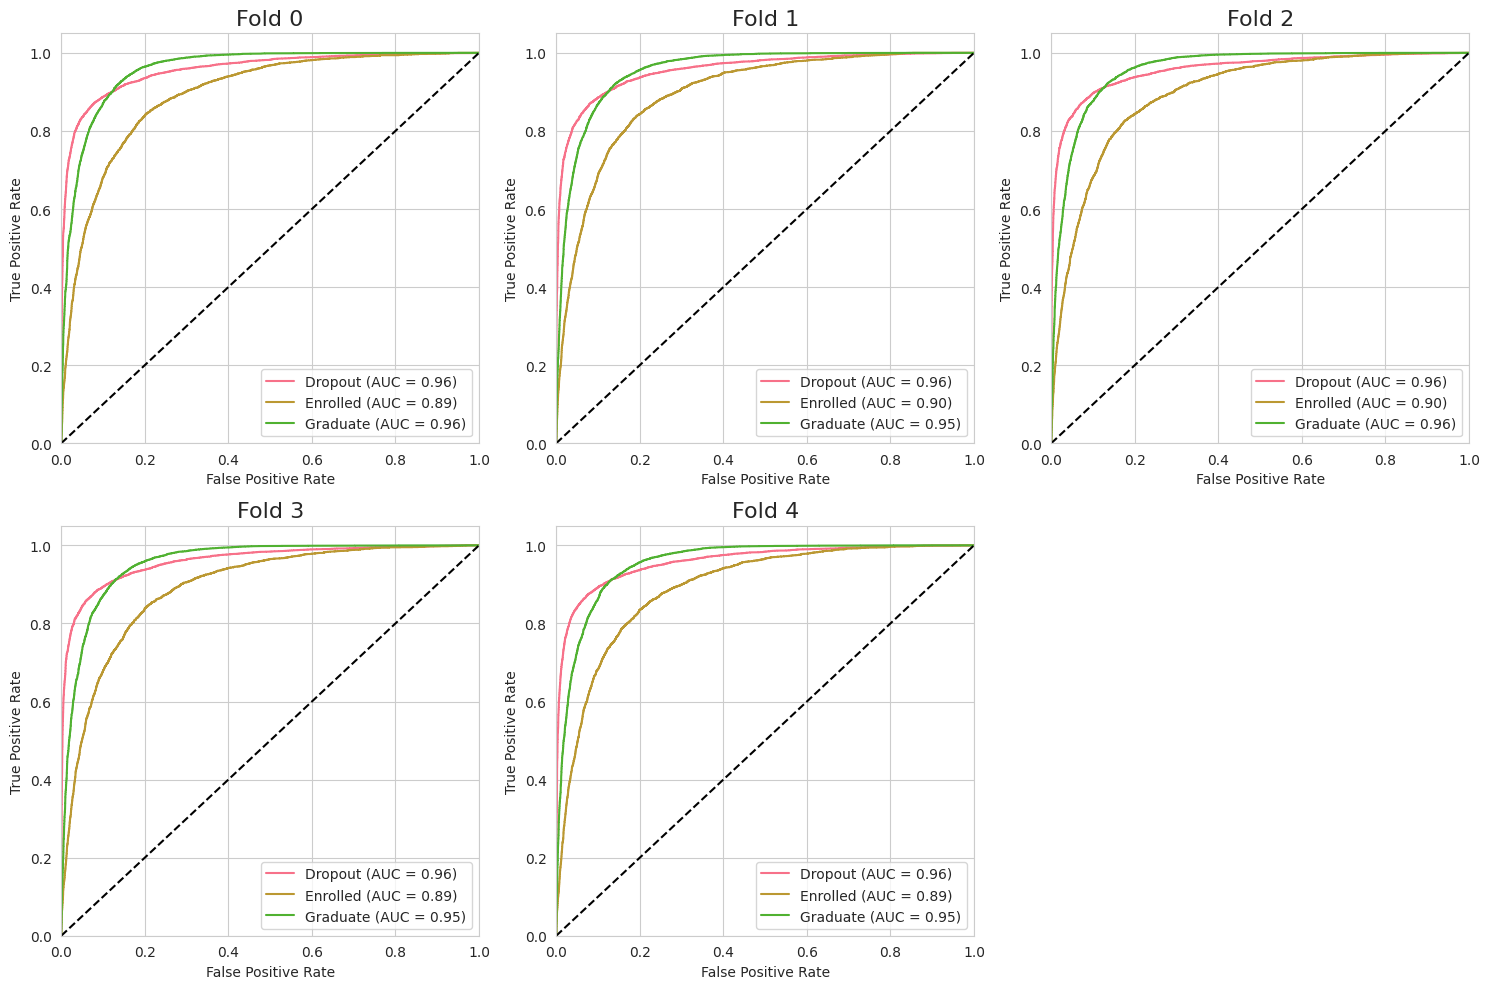

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    pred_probs = histories[f'Fold {fold_idx}']['pred_probs']
    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(pred_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y == i, pred_probs.values[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(pred_probs.shape[1]):
        ax.plot(fpr[i], tpr[i], label=f'{reverse_mappings[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

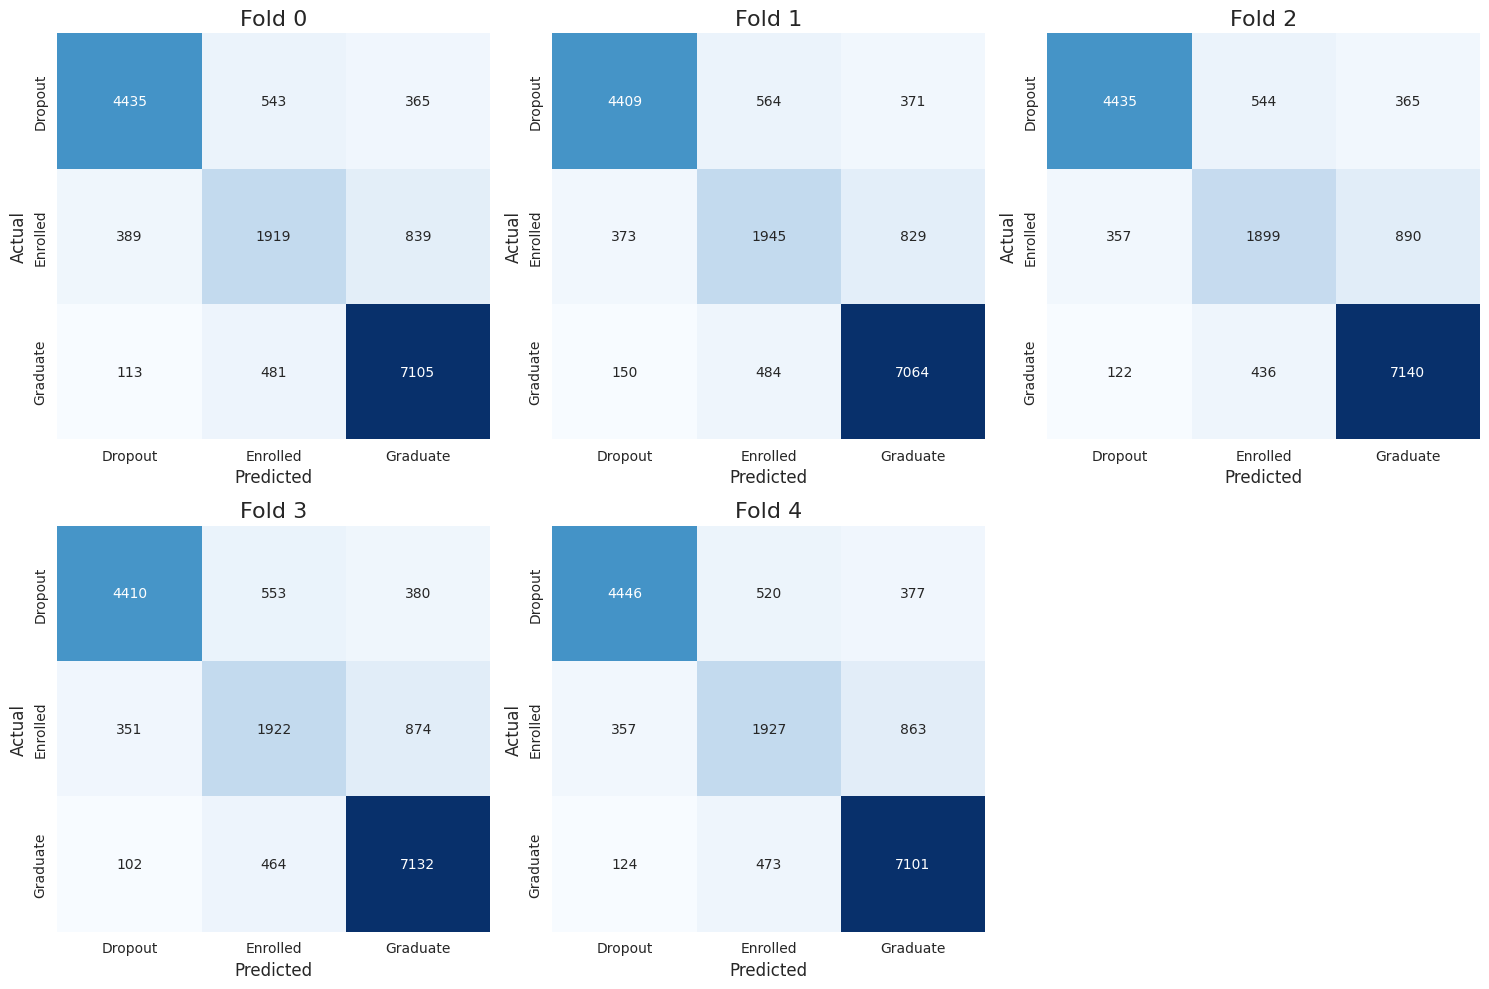

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    cm = confusion_matrix(y, preds)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        ax=ax,
        cmap='Blues',
        cbar=False,
        xticklabels=reverse_mappings.values(),
        yticklabels=reverse_mappings.values()
    )

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Fold {fold_idx}', fontsize=16)

plt.tight_layout()
plt.show()

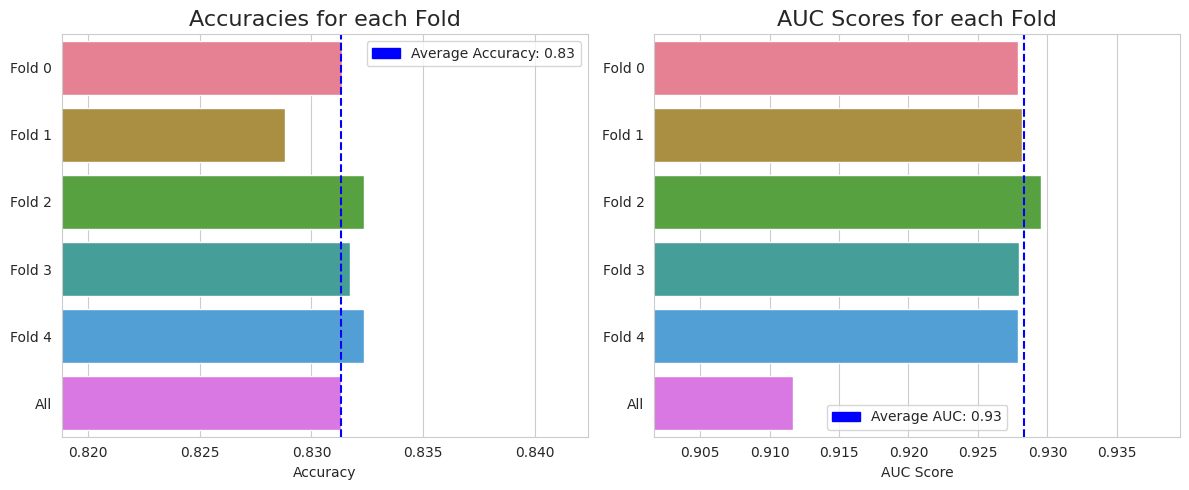

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

accuracies = [histories[f'Fold {i}']['accuracy'] for i in range(N_FOLDS)]
mean_accuracy = np.mean(accuracies)
accuracies = accuracies + [histories['All']['accuracy']]

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=accuracies, ax=axs[0], palette='husl', orient='h')
axs[0].axvline(mean_accuracy, color='b', linestyle='--')
axs[0].set_xlim([min(accuracies) - 0.01, max(accuracies) + 0.01])
axs[0].set_xlabel('Accuracy')
axs[0].set_title('Accuracies for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='b', label=f'Average Accuracy: {mean_accuracy:.2f}')
axs[0].legend(handles=[blue_patch], loc='best')


auc_scores = [histories[f'Fold {i}']['auc'] for i in range(N_FOLDS)]
mean_auc = np.mean(auc_scores)
auc_scores = auc_scores + [histories['All']['auc']]

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=auc_scores, ax=axs[1], palette='husl', orient='h')
axs[1].axvline(mean_auc, color='b', linestyle='--')
axs[1].set_xlim([min(auc_scores) - 0.01, max(auc_scores) + 0.01])
axs[1].set_xlabel('AUC Score')
axs[1].set_title('AUC Scores for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='b', label=f'Average AUC: {mean_auc:.2f}')
axs[1].legend(handles=[blue_patch], loc='best')

plt.tight_layout()
plt.show()

# Inference

In [18]:
files = glob.glob('fold_*_test_pred_probs_*.csv')
submissions = [pd.read_csv(f, index_col='id') for f in files]

submission = pd.concat(submissions, axis=1)
submission = submission.groupby(level=0, axis=1).mean()

submission['Target'] = submission.idxmax(axis=1)
submission['id'] = submission.index
submission = submission[['id', 'Target']]

submission.to_csv(f'sub_ag_acc_{mean_accuracy:.6f}_auc_{mean_auc:.6f}.csv', index=False)
submission.head()

,id,Target
id,,
76518,76518,Dropout
76519,76519,Graduate
76520,76520,Graduate
76521,76521,Graduate
76522,76522,Enrolled
